In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

In [17]:
# Fix CSVs so that they work with double difference
def arr_csv_by_HWP(csv_path, hwp_order, todelete=None, new_csv_path=None):
    """Arranges CSVs by a custom HWP order. Deletes selected angles.
    
    Parameters:
    -----------
    csv_path: str or Path
        CSV containing relevant headers, can be obtained from
        write_fits_info_to_csv().
    hwp_order: list or np.ndarray
        List of desired HWP order. 
    todelete: list or np.ndarray, optional
        Optional list of HWP angles to delete.
    new_csv_path: str or Path, optional
        Optional path to create the new csv. If set to None,
        the csv will be edited in place.
    
    Returns:
    ---------
    df: Pandas DataFrame
        Returns DataFrame for visual inspection of csv changes.
        
    """
    hwp_order = np.array(hwp_order)

    # Load to a DF and sort

    df = pd.read_csv(csv_path)
    hwp_angles = df['RET-ANG1']
    if todelete:
        todelete = np.array(todelete)
        indices = np.where(np.isin(df['RET-ANG1'],todelete))[0]
        df = df.drop(indices)
    # Ensure the pattern loops correctly

    npattern = len(hwp_angles) // len(hwp_order)
    remainder = len(hwp_angles) % len(hwp_order)
    hwp_pattern = np.tile(hwp_order,npattern)
    hwp_pattern = np.concatenate((hwp_pattern,hwp_order[:remainder]))

    # Modify the DF

    df["RET-ANG1"] = pd.Categorical(df['RET-ANG1'],categories=hwp_order,ordered=True)
    df = df.sort_values(by=['D_IMRANG','RET-ANG1'])

    if new_csv_path:
        df.to_csv(new_csv_path,index=False)
    else:
        df.to_csv(csv_path,index=False)
    return df

    

In [2]:
hwp_order = [0,45,11.25,56.25,22.5,67.5,33.75,78.75]
for bin in range(0,22):
    csv = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'
    csv_new = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff_dd.csv'
    arr_csv_by_HWP(csv,hwp_order,todelete=[90.0],new_csv_path=csv_new)

NameError: name 'arr_csv_by_HWP' is not defined

Interleaved Values
Length:  128
[-5.29888721e-01  3.94488401e+08  5.88668204e-01  3.92806254e+08
 -3.97088140e-01  3.94805602e+08  4.83611945e-01  3.92081635e+08
 -2.57682445e-02  3.91964053e+08]
Interleaved Stds
Length:  128
[4.26985511e-05 1.98617321e+04 4.07871675e-05 1.98193404e+04
 4.61899150e-05 1.98697157e+04 4.42038406e-05 1.98010514e+04
 5.04931710e-05 1.97980821e+04]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'th

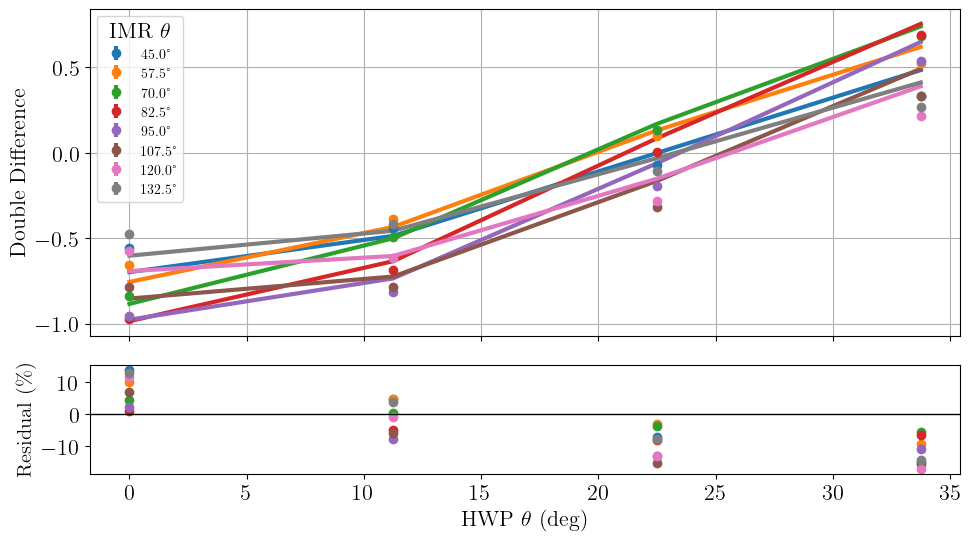

In [2]:
# Plot data with original model
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea,
# bin zero can be finicky
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff_dd.csv')
#filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4_fixed2.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])

# Load in past fits

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "rotation matrix": {
                "type": "rotator_function",
                "properties" : {'pa':offset_cal},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon":1},
                "tag": "internal",
            }}
    }

system_mm = generate_system_mueller_matrix(system_dict)

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[15], IMR_retardance(wavelength_bins)[15]]

# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved double diffs and sums

diffs_sums = process_model(LR_intensities)


fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[15], mode='CHARIS',title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)
# Print residuals (will be useful later to see if your fit improved at a quick glance)



dataset: [-0.55921567 -0.44020028 -0.07269156  0.3356562  -0.65443234 -0.38667083
  0.09953449  0.52685508 -0.83909331 -0.4954223   0.13263803  0.68267184
 -0.97483384 -0.68347837  0.0041333   0.68971106 -0.954114   -0.81184901
 -0.19298174  0.53918837 -0.78332678 -0.78354157 -0.31775628  0.33528647
 -0.57646284 -0.61276723 -0.28130044  0.218281   -0.47235913 -0.41854034
 -0.10874783  0.26755814]
errors: [3.56395605e-05 3.56489179e-05 3.57197353e-05 3.56504148e-05
 3.56256481e-05 3.57034284e-05 3.57734326e-05 3.56737909e-05
 3.56457552e-05 3.57305073e-05 3.58223832e-05 3.57250599e-05
 3.56209407e-05 3.56991760e-05 3.58216674e-05 3.57147728e-05
 3.55444439e-05 3.56068204e-05 3.57477895e-05 3.56869897e-05
 3.54790295e-05 3.54895357e-05 3.56189401e-05 3.56056470e-05
 3.53822759e-05 3.54179472e-05 3.54878188e-05 3.54799276e-05
 3.52836663e-05 3.53148781e-05 3.54044987e-05 3.53723952e-05]
model: [-0.69819254 -0.48626071 -0.00111633  0.48464284 -0.75561804 -0.43366434
  0.1317795   0.6199932

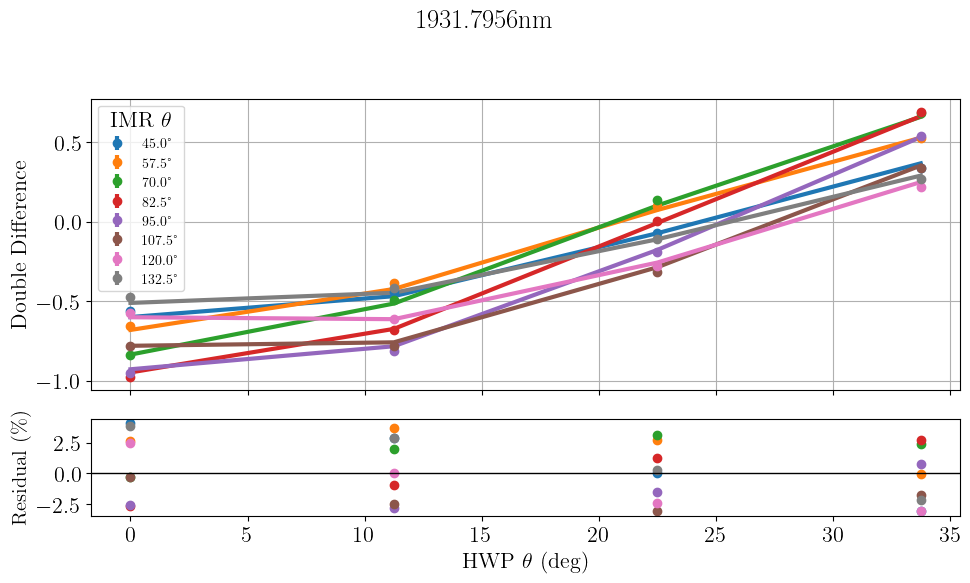

Updated Mueller Matrix:
[[ 0.32514002  0.30008741  0.05368679  0.11305445]
 [-0.32514002 -0.30008741 -0.05368679 -0.11305445]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.030883219112542548 0.04076514032717449
Error: [0.01555031 0.55472457 0.03224046 3.74942088 7.47183309 0.01049565]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/dd_fit_dicts/test.json'

In [3]:
# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2 = fit_CHARIS_Mueller_matrix_by_bin(filepath, 15, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/dd_fit_dicts/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



dataset: [ 0.4618941   0.36293134  0.06464694 -0.27043001  0.14541861  0.4929013
  0.56982712  0.31052397 -0.45399349  0.13354313  0.65606866  0.7934812
 -0.91829663 -0.4690107   0.26765456  0.8443624  -0.93691375 -0.89038314
 -0.32567047  0.43586954 -0.51378145 -0.84800194 -0.69522825 -0.13442254
  0.0396233  -0.37729727 -0.58840776 -0.45055631  0.30963423  0.17942734
 -0.07429825 -0.28451008]
errors: [0.00016982 0.00016947 0.00016984 0.00016933 0.00016926 0.00016946
 0.00016993 0.00016949 0.00016958 0.00016977 0.00017045 0.00017017
 0.0001712  0.00016993 0.0001702  0.00017044 0.00017018 0.00017038
 0.00017025 0.00016982 0.00016907 0.00017023 0.0001702  0.00016949
 0.00016869 0.00016936 0.00017007 0.00016939 0.00016837 0.00016897
 0.00016968 0.00016923]
model: [ 2.48920206e-01  1.64534626e-01 -1.13567171e-04 -1.64641000e-01
  3.23188203e-02  3.30713730e-01  4.49993091e-01  3.05721765e-01
 -4.65659718e-01  7.23022557e-02  5.78277075e-01  7.45539905e-01
 -8.98766312e-01 -4.31245339e-01 

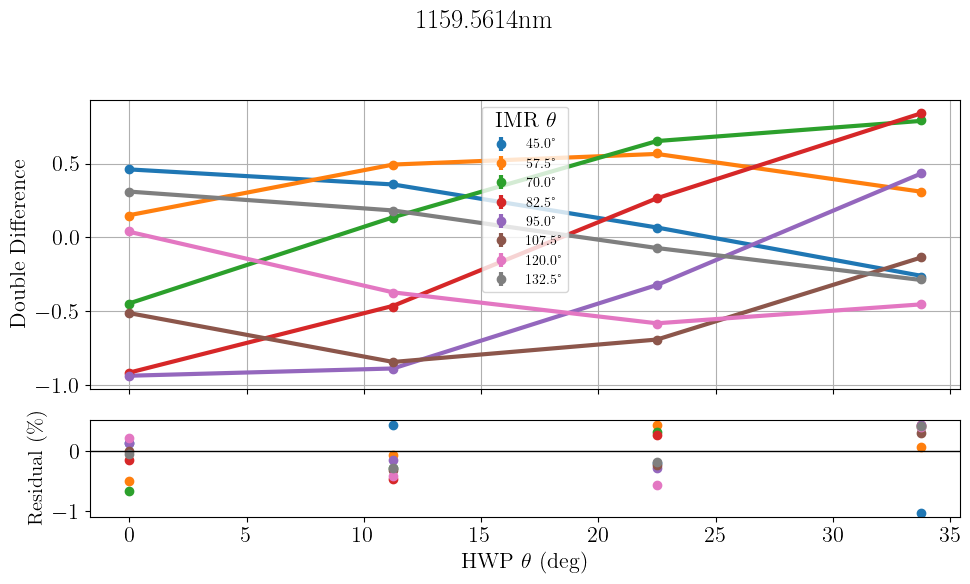

Updated Mueller Matrix:
[[ 6.92790117e-01  6.92790117e-01 -7.87056959e-10 -6.82925561e-09]
 [-6.92790117e-01 -6.92790117e-01  7.87056959e-10  6.82925561e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
32 64
Residuals range: -0.010282536286521538 0.004467156992405741
Error: [0.00172118 0.05391611 0.00413748 0.43236618 0.84575061 0.00176715]
dataset: [ 0.66788094  0.52606435  0.08917284 -0.40130119  0.31128136  0.67122131
  0.66068209  0.26003048 -0.37290764  0.26033305  0.75094046  0.80956109
 -0.90665324 -0.42687814  0.29899867  0.85479723 -0.91158198 -0.90907032
 -0.37596989  0.36936763 -0.39862699 -0.84228282 -0.79432571 -0.28842041
  0.24211816 -0.28247791 -0.65928707 -0.64502677  0.54917863  0.35732348
 -0.06474594 -0.45061104]
errors: [0.00016534 0.0001653  0.00016552 0.00016535 0.00016535 0.00016522
 0.00016568 0.00016574 0.00016604 0.00016567 0.00016591 0.00016641
 0.00016664 0.00016611 0

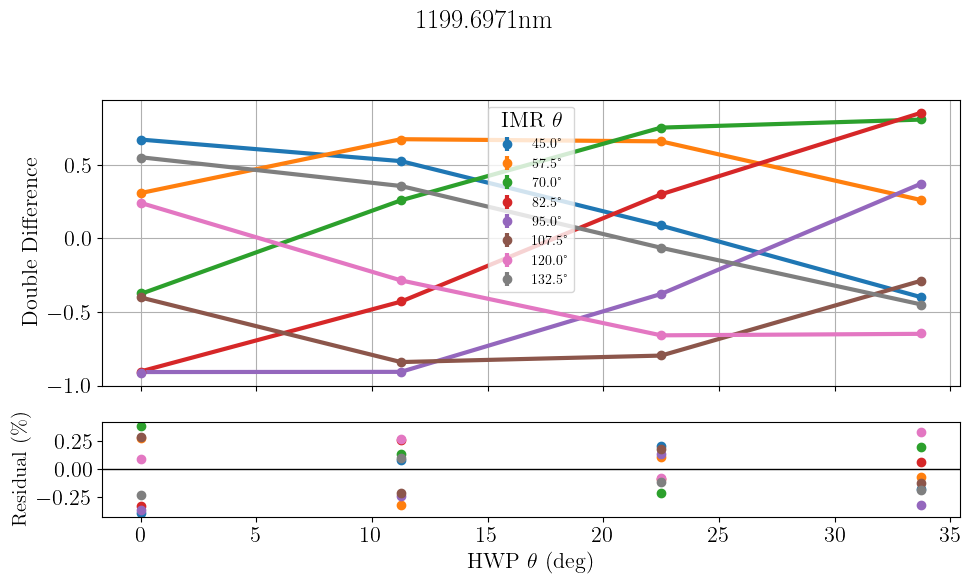

Updated Mueller Matrix:
[[ 0.76530838  0.76268983 -0.02194581 -0.05932556]
 [-0.76530838 -0.76268983  0.02194581  0.05932556]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.003837331948046252 0.0038526878085470284
Error: [0.00134552 0.04937043 0.002945   0.3088466  0.59285595 0.00105971]
dataset: [ 0.814461    0.63322153  0.09342746 -0.50162938  0.42631254  0.80531421
  0.72809288  0.22294564 -0.31977105  0.35728698  0.83765588  0.82872004
 -0.89971752 -0.39557315  0.34261943  0.88337283 -0.90417683 -0.92411294
 -0.4044551   0.35037266 -0.34059155 -0.85325969 -0.87301668 -0.38195886
  0.37625464 -0.23953041 -0.72916535 -0.78989063  0.73052849  0.47473316
 -0.0738062  -0.57996517]
errors: [0.0001422  0.00014198 0.00014204 0.00014191 0.00014191 0.00014205
 0.0001422  0.00014204 0.00014218 0.00014224 0.00014251 0.00014247
 0.00014267 0.00014231 0.00014242 0.00014258 0.00014233 0.00014242
 0.0001423  0.000142

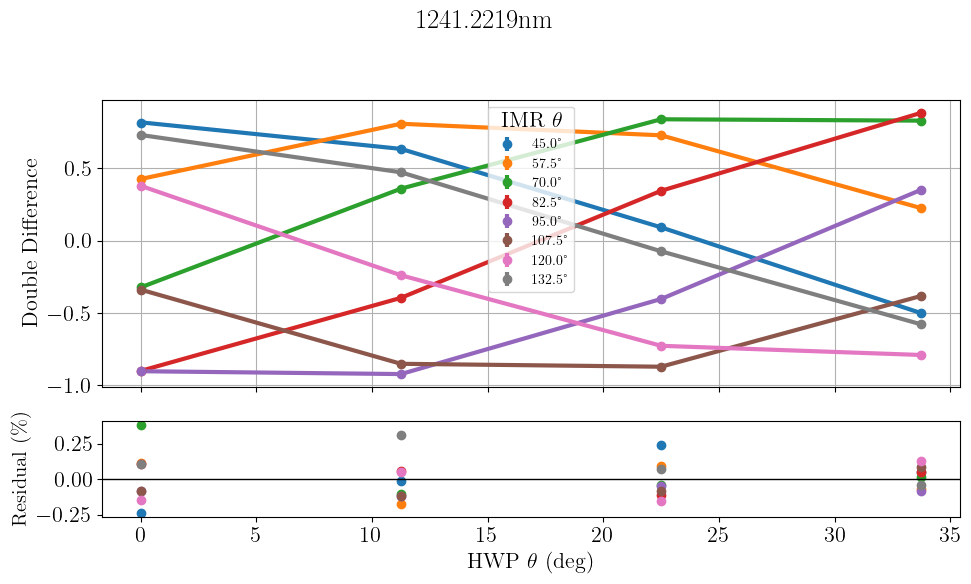

Updated Mueller Matrix:
[[ 0.81954536  0.81815193 -0.02690785 -0.03947129]
 [-0.81954536 -0.81815193  0.02690785  0.03947129]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.0023515245005312213 0.003795976095716913
Error: [0.00112486 0.05203798 0.00224764 0.27755977 0.52491573 0.00065035]
dataset: [ 0.92433376  0.7212469   0.10060019 -0.57898854  0.51431139  0.90737234
  0.78220744  0.19466917 -0.27870774  0.43482025  0.90246344  0.84400274
 -0.89519917 -0.36517322  0.37513005  0.90087383 -0.89098044 -0.92847359
 -0.42222781  0.32590226 -0.27512971 -0.84780082 -0.92413092 -0.46095665
  0.4989897  -0.18433989 -0.77098168 -0.9001173   0.87967324  0.57908221
 -0.07133314 -0.68049862]
errors: [0.00012761 0.00012745 0.00012739 0.00012733 0.00012743 0.00012746
 0.00012765 0.0001275  0.00012777 0.00012767 0.0001279  0.00012811
 0.00012841 0.00012785 0.00012774 0.00012818 0.00012815 0.00012808
 0.00012761 0.000127

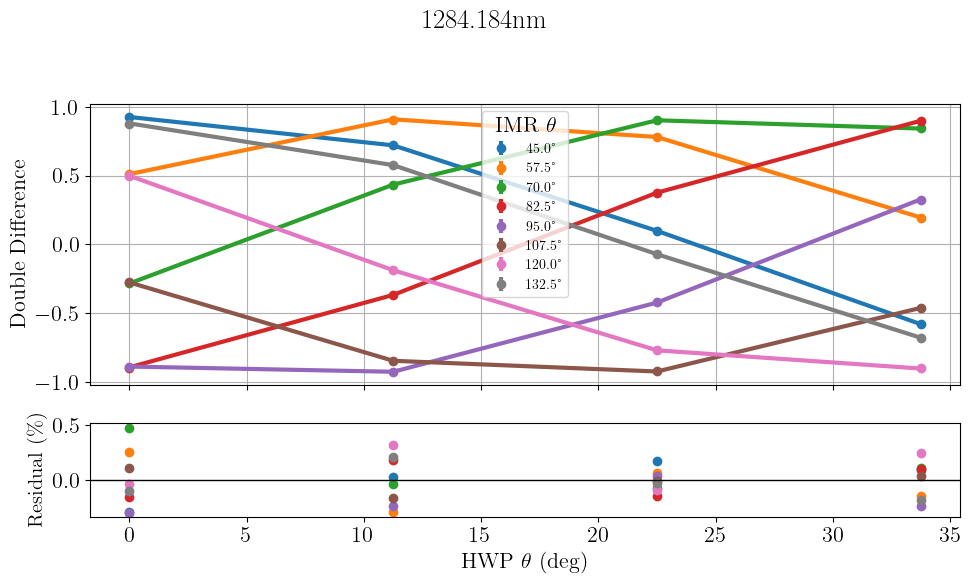

Updated Mueller Matrix:
[[ 0.85658389  0.85455724 -0.04778521 -0.03441596]
 [-0.85658389 -0.85455724  0.04778521  0.03441596]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.0029079967091280023 0.0047685088890278005
Error: [2.70675061e-03 1.98881048e-01 4.99871242e-03 7.29213135e-01
 1.28691009e+00 9.13188388e-04]
dataset: [ 0.96565967  0.75552485  0.10221622 -0.61164771  0.54298258  0.95430574
  0.81088929  0.18850072 -0.26857359  0.46877404  0.93978157  0.85879879
 -0.89630474 -0.35139613  0.39605479  0.91695615 -0.88489058 -0.92792394
 -0.42615577  0.32054171 -0.24390913 -0.84214902 -0.94734573 -0.49574818
  0.56120105 -0.15924535 -0.79170255 -0.95797153  0.9648129   0.63040144
 -0.07294309 -0.73454529]
errors: [0.00010904 0.00010893 0.0001089  0.00010883 0.00010882 0.00010897
 0.00010911 0.00010893 0.00010905 0.00010907 0.00010934 0.00010935
 0.00010948 0.0001091  0.00010915 0.00010937 0.0001092  0.000

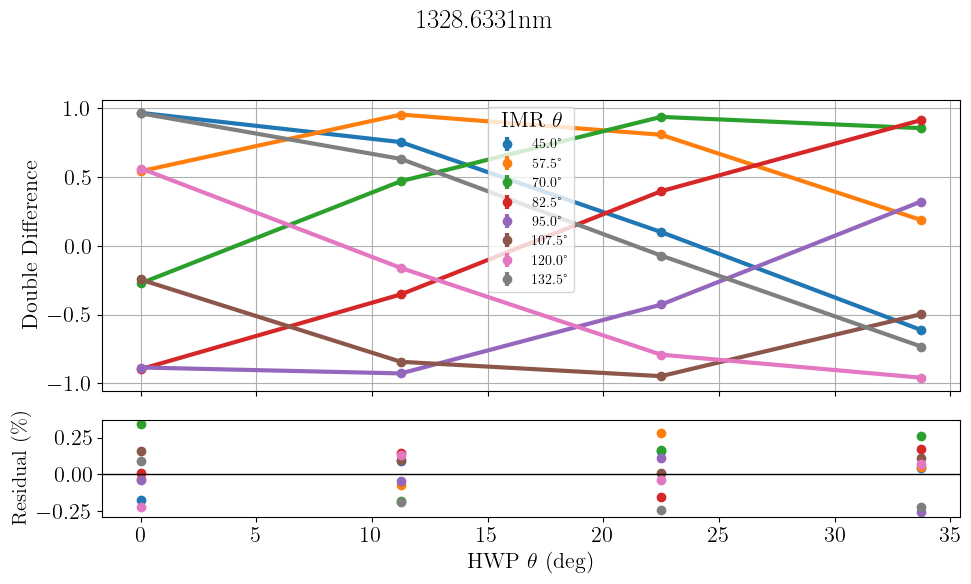

Updated Mueller Matrix:
[[ 0.86819023  0.86599238 -0.0597658  -0.01547685]
 [-0.86819023 -0.86599238  0.0597658   0.01547685]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.002603968202387008 0.0034166478309823334
Error: [5.74913599e-03 1.03481228e+00 1.02220869e-02 5.08158366e+00
 9.48526578e+00 7.60506444e-04]
dataset: [ 0.88306663  0.69171936  0.08742868 -0.56822314  0.4758738   0.89348011
  0.78062112  0.20819266 -0.30418099  0.42811194  0.91208278  0.85932355
 -0.9042241  -0.35992553  0.38892121  0.91547438 -0.88502623 -0.91364497
 -0.40500661  0.33674198 -0.25711768 -0.83010664 -0.91278051 -0.45824637
  0.53146086 -0.16913051 -0.76811842 -0.91522201  0.93172838  0.59614576
 -0.07797143 -0.70668095]
errors: [5.01376873e-05 5.00656346e-05 5.00409371e-05 4.99892321e-05
 4.99824560e-05 5.00931866e-05 5.01213706e-05 5.00380987e-05
 5.00675865e-05 5.00728498e-05 5.01934881e-05 5.01966088e-05
 5.02101056e-

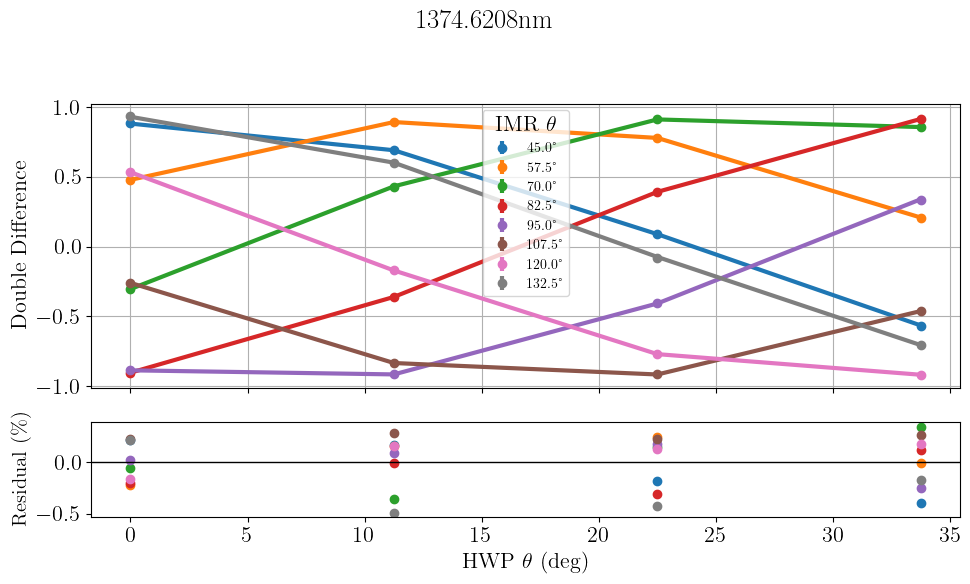

Updated Mueller Matrix:
[[ 0.83899888  0.83683658 -0.05297582  0.02858681]
 [-0.83899888 -0.83683658  0.05297582 -0.02858681]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.004895320121782509 0.003504026614903233
Error: [3.44312372e-03 2.53880794e-01 6.54413154e-03 9.21208601e-01
 1.60423661e+00 1.05746953e-03]
dataset: [ 0.72052611  0.57338739  0.0726883  -0.47220008  0.34932279  0.75942412
  0.71711486  0.24841594 -0.36798588  0.33552828  0.83874437  0.85139402
 -0.91639688 -0.3890464   0.35534136  0.89812902 -0.88686646 -0.89699707
 -0.37833115  0.35504974 -0.29290106 -0.81331317 -0.84647484 -0.38401747
  0.44313103 -0.19777899 -0.71353143 -0.80702445  0.81401258  0.50905436
 -0.07815762 -0.61873935]
errors: [7.21725930e-05 7.21650580e-05 7.21637811e-05 7.20697866e-05
 7.20505933e-05 7.21494085e-05 7.23056332e-05 7.21941009e-05
 7.22379390e-05 7.21818449e-05 7.23881305e-05 7.24871658e-05
 7.25433165e-0

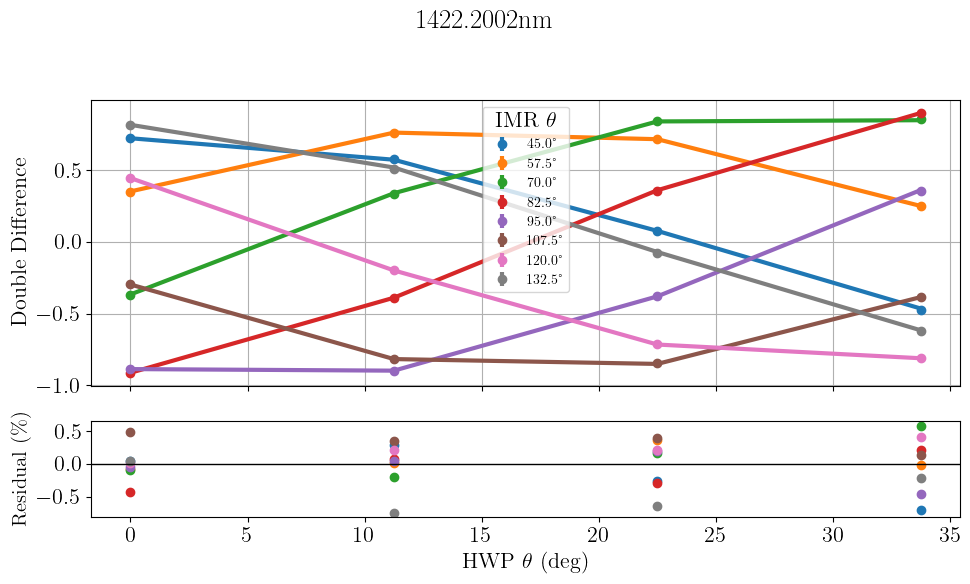

Updated Mueller Matrix:
[[ 0.78098033  0.77791926 -0.04868775  0.04900397]
 [-0.78098033 -0.77791926  0.04868775 -0.04900397]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.007407997378803932 0.005789839138277686
Error: [0.00273642 0.12543147 0.00561726 0.62036962 1.15343639 0.00147753]
dataset: [ 0.50891685  0.407697    0.04627974 -0.3450909   0.17987519  0.57775704
  0.62203652  0.29702518 -0.45183761  0.20494153  0.7328716   0.83169229
 -0.93016405 -0.43339744  0.30699265  0.87143761 -0.8949624  -0.87805518
 -0.34377799  0.38823758 -0.36075345 -0.80132747 -0.75955906 -0.272297
  0.30075337 -0.25321424 -0.64422823 -0.65347097  0.63565057  0.37712234
 -0.08117902 -0.49008915]
errors: [7.41768308e-05 7.41553350e-05 7.41668984e-05 7.40836642e-05
 7.40672538e-05 7.41558425e-05 7.42315793e-05 7.41950154e-05
 7.42085554e-05 7.41755771e-05 7.42868861e-05 7.43597232e-05
 7.43525174e-05 7.41544392e-05 7.41534693

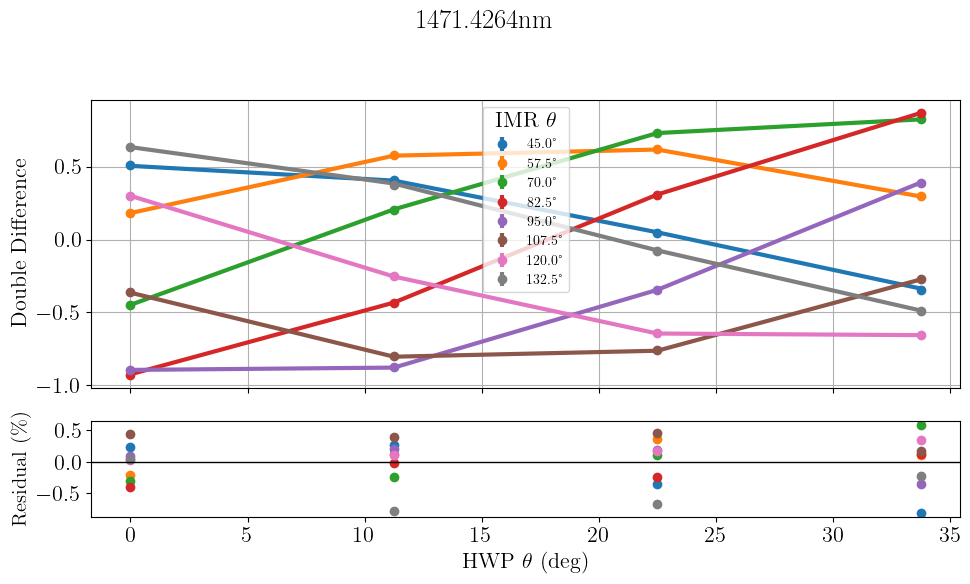

Updated Mueller Matrix:
[[ 0.70528773  0.70175497 -0.03577429  0.06075316]
 [-0.70528773 -0.70175497  0.03577429 -0.06075316]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.008036777934554484 0.0058407099583256405
Error: [0.00195503 0.06872008 0.00444519 0.46146091 0.88742144 0.0015392 ]
dataset: [ 0.28155125  0.23121018  0.02099911 -0.2042468   0.0041872   0.38100364
  0.51808128  0.34660303 -0.5343142   0.06731252  0.61681165  0.80687396
 -0.94161438 -0.47687595  0.25325087  0.83980164 -0.90449166 -0.85769922
 -0.30489156  0.42050617 -0.43643428 -0.78942567 -0.66408011 -0.15100981
  0.1377011  -0.31615868 -0.56836275 -0.48269103  0.42955218  0.22611473
 -0.08717763 -0.34716402]
errors: [7.73201929e-05 7.73159461e-05 7.73291567e-05 7.72189840e-05
 7.72445306e-05 7.72994114e-05 7.74153843e-05 7.73814262e-05
 7.74405903e-05 7.73679892e-05 7.74703496e-05 7.75839514e-05
 7.76251190e-05 7.73646701e-05 7.72984

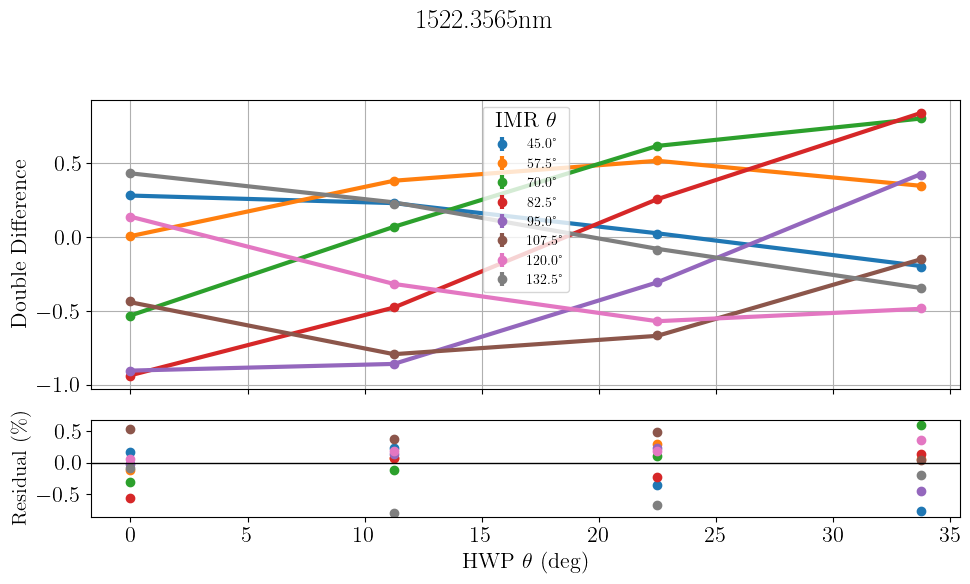

Updated Mueller Matrix:
[[ 0.62612759  0.62119562 -0.02624687  0.07391118]
 [-0.62612759 -0.62119562  0.02624687 -0.07391118]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.007885946868420673 0.00601931702197589
Error: [0.00160169 0.04936623 0.00398377 0.38871849 0.75739916 0.0015754 ]
dataset: [ 7.75391443e-02  7.15619862e-02 -3.46407361e-04 -7.47647603e-02
 -1.58111198e-01  2.00341717e-01  4.23657837e-01  3.95120392e-01
 -6.13278892e-01 -6.49504739e-02  5.07206928e-01  7.84155760e-01
 -9.52686365e-01 -5.25621759e-01  1.97741173e-01  8.08069320e-01
 -9.13354283e-01 -8.45035300e-01 -2.78268159e-01  4.47657736e-01
 -5.08726215e-01 -7.83626795e-01 -5.83389069e-01 -4.27783994e-02
 -1.46844917e-02 -3.77997920e-01 -5.01600675e-01 -3.26864033e-01
  2.34270082e-01  8.48123523e-02 -9.19637519e-02 -2.12399492e-01]
errors: [7.00814880e-05 7.00791456e-05 7.01502036e-05 7.00329211e-05
 7.00444887e-05 7.00795268e-05 7

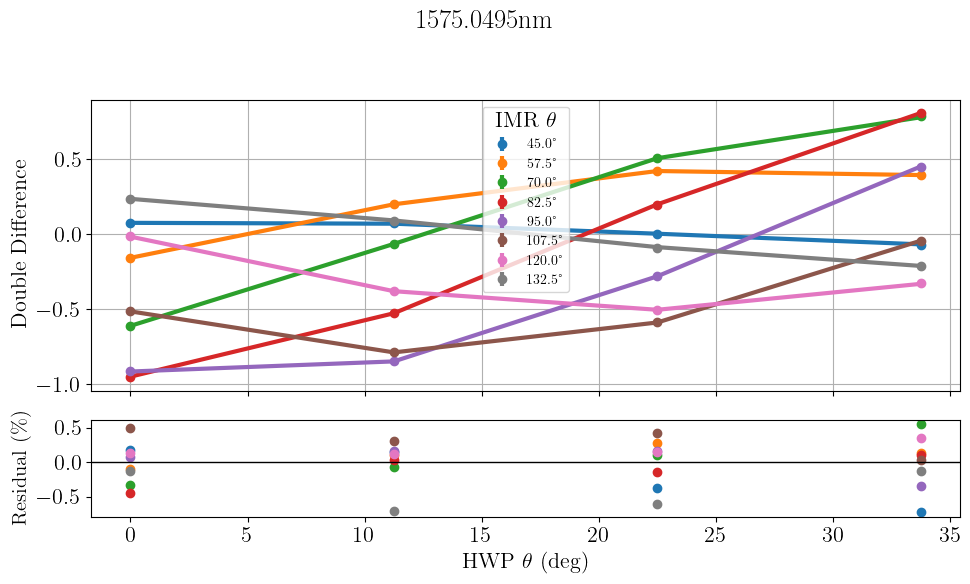

Updated Mueller Matrix:
[[ 0.55522324  0.5502326  -0.0139705   0.07295043]
 [-0.55522324 -0.5502326   0.0139705  -0.07295043]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.007289734728711764 0.005463258126827464
Error: [0.00130146 0.03803658 0.00337235 0.31870003 0.62549789 0.00140777]
dataset: [-0.1190966  -0.08480113 -0.02419972  0.04700036 -0.31251421  0.023228
  0.32617369  0.43489747 -0.68571275 -0.1933501   0.39645362  0.75559416
 -0.96182901 -0.57084222  0.14207492  0.77376865 -0.92268212 -0.83148845
 -0.25013674  0.47391841 -0.58124043 -0.77710822 -0.50171575  0.06647878
 -0.16828576 -0.43901604 -0.43346076 -0.16995372  0.04049739 -0.05455892
 -0.09456363 -0.07560611]
errors: [6.08159533e-05 6.07938442e-05 6.08074079e-05 6.07432825e-05
 6.07838003e-05 6.08133648e-05 6.08689155e-05 6.08509585e-05
 6.08824119e-05 6.08826791e-05 6.09213388e-05 6.09397504e-05
 6.09369554e-05 6.08661887e-05 6.08674388

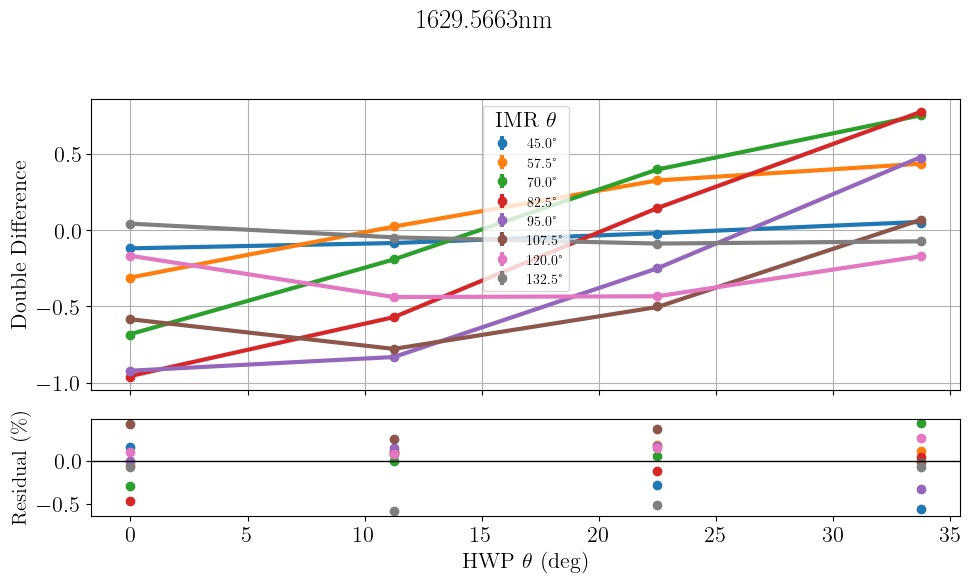

Updated Mueller Matrix:
[[ 0.48633144  0.48047837 -0.00311301  0.07516062]
 [-0.48633144 -0.48047837  0.00311301 -0.07516062]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.005890757416561282 0.004316473955405464
Error: [0.00108983 0.03154659 0.00277827 0.26833755 0.52985491 0.00117408]
dataset: [-0.27408234 -0.20816744 -0.04183663  0.14613792 -0.43315448 -0.11668334
  0.25026484  0.46797965 -0.7415216  -0.29436961  0.30981833  0.733614
 -0.96767714 -0.60711663  0.09931413  0.74839985 -0.93216002 -0.82180951
 -0.22756605  0.4977138  -0.64532907 -0.77545484 -0.43691317  0.15619027
 -0.29742725 -0.49271161 -0.38071407 -0.04228273 -0.12209499 -0.17107203
 -0.09882303  0.0349599 ]
errors: [6.17120077e-05 6.16854022e-05 6.17139936e-05 6.16382155e-05
 6.16757181e-05 6.17208035e-05 6.17710800e-05 6.17397817e-05
 6.17650034e-05 6.18126675e-05 6.18427435e-05 6.18091096e-05
 6.17679452e-05 6.17735280e-05 6.18272709

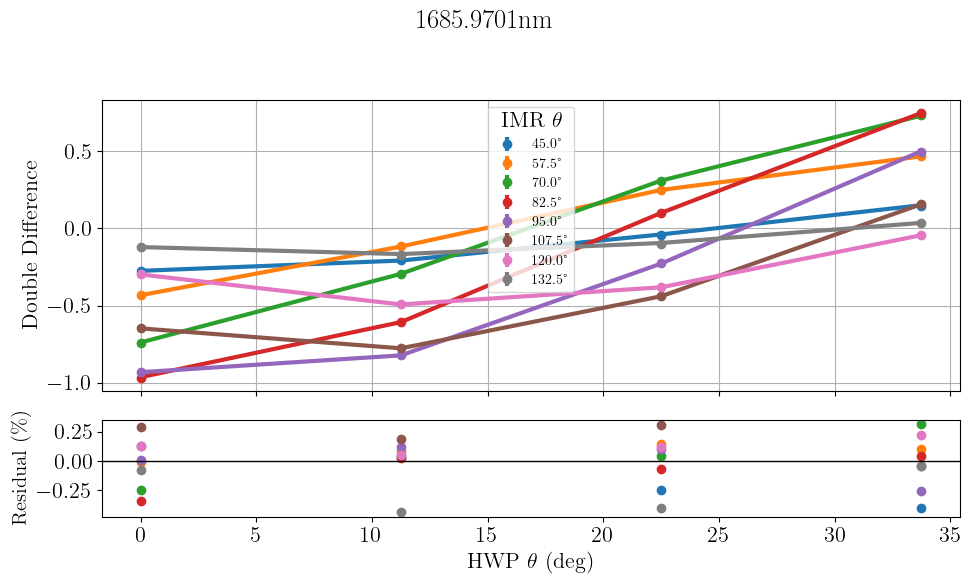

Updated Mueller Matrix:
[[ 0.4331618   0.42743583  0.00579679  0.06995824]
 [-0.4331618  -0.42743583 -0.00579679 -0.06995824]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.00441036471119427 0.003131847917426933
Error: [0.00088598 0.02623079 0.00216206 0.21293014 0.42186921 0.00089306]
dataset: [-0.37866169 -0.29130697 -0.05183466  0.21581711 -0.51555393 -0.21275053
  0.19867558  0.49236527 -0.77948556 -0.36622159  0.24897852  0.7189959
 -0.97193942 -0.6343366   0.06647059  0.72918043 -0.93908224 -0.8178397
 -0.2154446   0.51174901 -0.6907356  -0.77665983 -0.39563342  0.21665297
 -0.3916157  -0.53317438 -0.34679519  0.04538971 -0.24007542 -0.2562883
 -0.10397707  0.11195264]
errors: [5.84993664e-05 5.84751874e-05 5.85073966e-05 5.84417640e-05
 5.84793166e-05 5.85245040e-05 5.85736708e-05 5.85284175e-05
 5.85411685e-05 5.85901727e-05 5.86380528e-05 5.85994798e-05
 5.85474845e-05 5.85503923e-05 5.85956892e-

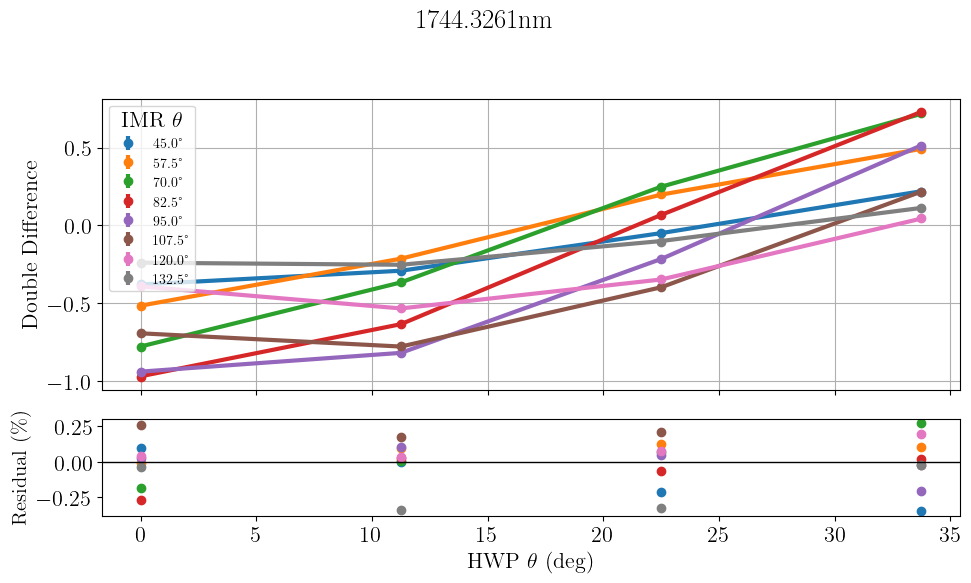

Updated Mueller Matrix:
[[ 0.39850814  0.39328705  0.0112982   0.06329595]
 [-0.39850814 -0.39328705 -0.0112982  -0.06329595]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.0034829168730707016 0.002711015035518849
Error: [0.00077604 0.0237321  0.00181825 0.18308163 0.36345022 0.00072368]
dataset: [-0.46105261 -0.35959413 -0.06350446  0.26723011 -0.58014082 -0.29196321
  0.15272744  0.50681469 -0.80851085 -0.42511925  0.19562095  0.70273771
 -0.97402032 -0.65768784  0.03743119  0.71099902 -0.94398433 -0.81522868
 -0.20674832  0.52180647 -0.72758734 -0.77827523 -0.36202048  0.26583342
 -0.46683253 -0.56568996 -0.31800414  0.11803539 -0.33562568 -0.3240441
 -0.10587847  0.17738951]
errors: [4.22754748e-05 4.22693447e-05 4.23079383e-05 4.22490332e-05
 4.22360582e-05 4.23064579e-05 4.23562494e-05 4.22916848e-05
 4.22652675e-05 4.23577780e-05 4.24061605e-05 4.23122361e-05
 4.22698034e-05 4.22904917e-05 4.240257

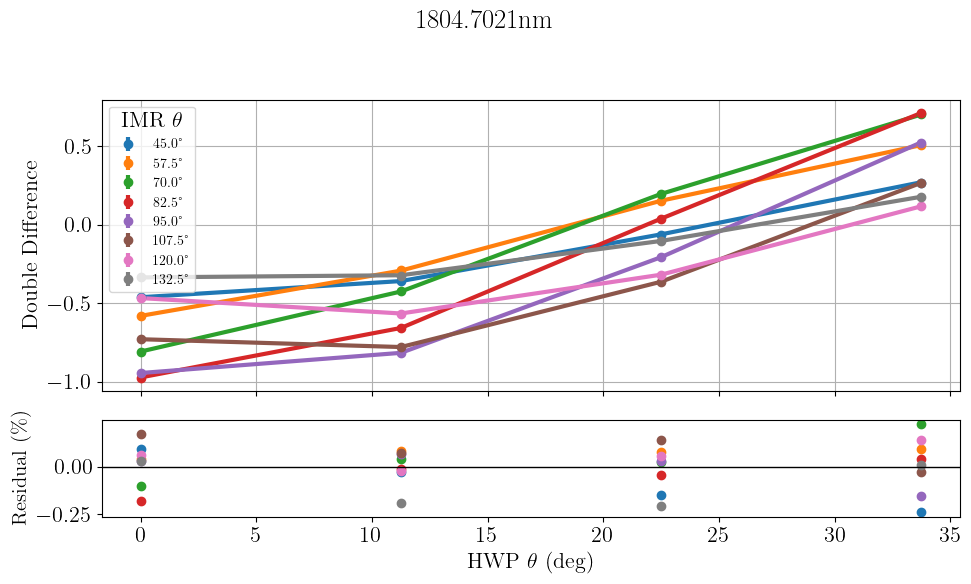

Updated Mueller Matrix:
[[ 0.37065416  0.36522954  0.01654572  0.06097645]
 [-0.37065416 -0.36522954 -0.01654572 -0.06097645]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.0024289951599520965 0.0022614658612953864
Error: [0.00057983 0.01843169 0.00129876 0.14297739 0.28441336 0.00049847]
dataset: [-0.52480439 -0.41169355 -0.07063818  0.30974486 -0.62926817 -0.35247066
  0.11915352  0.51969524 -0.82974734 -0.47006301  0.15651056  0.69095859
 -0.97614485 -0.67459981  0.01670853  0.69847051 -0.95075244 -0.8133174
 -0.19828399  0.53326387 -0.76143427 -0.78096333 -0.33437765  0.30900925
 -0.53348578 -0.59382668 -0.2949396   0.17997991 -0.41817864 -0.38124972
 -0.10712779  0.23303616]
errors: [2.33673812e-05 2.33668469e-05 2.33939646e-05 2.33580203e-05
 2.33427089e-05 2.33926078e-05 2.34229398e-05 2.33773800e-05
 2.33758027e-05 2.34163823e-05 2.34513498e-05 2.34080620e-05
 2.33595154e-05 2.33827420e-05 2.34409

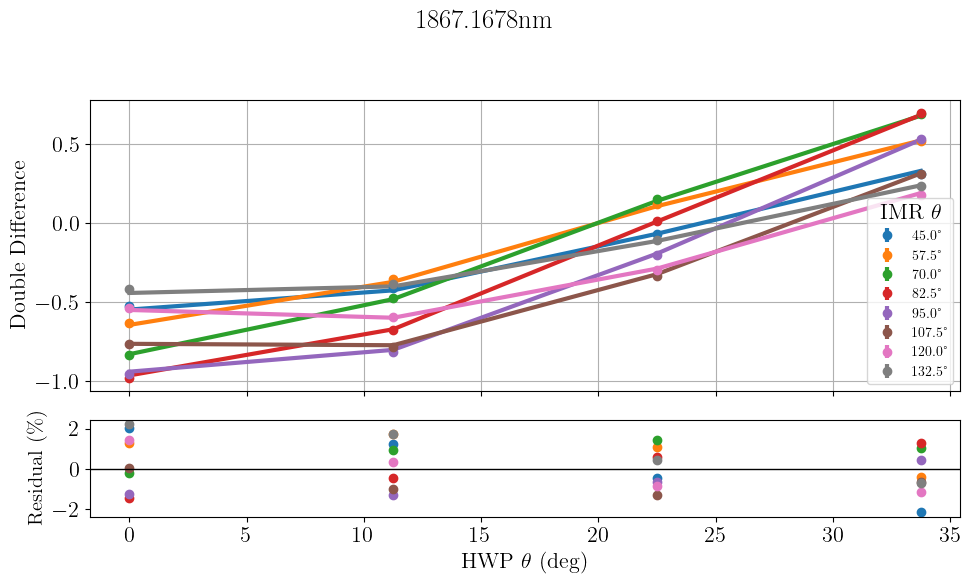

Updated Mueller Matrix:
[[ 0.34431597  0.33026202  0.03411892  0.09119421]
 [-0.34431597 -0.33026202 -0.03411892 -0.09119421]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.02170443859570559 0.022278532768714554
Error: [0.00688007 0.23171881 0.01483766 1.57332203 3.13143498 0.00519971]
dataset: [-0.55921567 -0.44020028 -0.07269156  0.3356562  -0.65443234 -0.38667083
  0.09953449  0.52685508 -0.83909331 -0.4954223   0.13263803  0.68267184
 -0.97483384 -0.68347837  0.0041333   0.68971106 -0.954114   -0.81184901
 -0.19298174  0.53918837 -0.78332678 -0.78354157 -0.31775628  0.33528647
 -0.57646284 -0.61276723 -0.28130044  0.218281   -0.47235913 -0.41854034
 -0.10874783  0.26755814]
errors: [3.56395605e-05 3.56489179e-05 3.57197353e-05 3.56504148e-05
 3.56256481e-05 3.57034284e-05 3.57734326e-05 3.56737909e-05
 3.56457552e-05 3.57305073e-05 3.58223832e-05 3.57250599e-05
 3.56209407e-05 3.56991760e-05 3.5821667

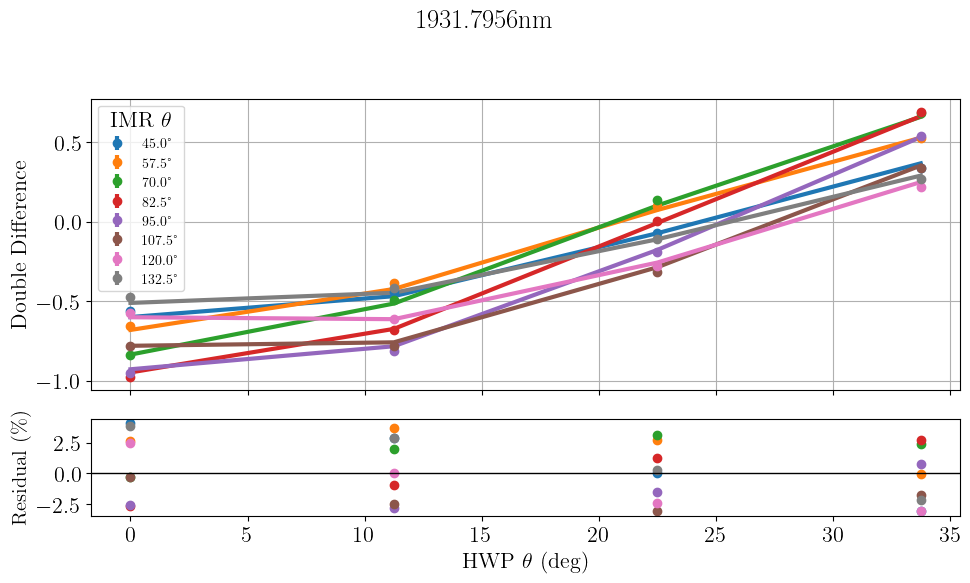

Updated Mueller Matrix:
[[ 0.32514002  0.30008741  0.05368679  0.11305445]
 [-0.32514002 -0.30008741 -0.05368679 -0.11305445]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.030883219112542548 0.04076514032717449
Error: [0.01555031 0.55472457 0.03224046 3.74942088 7.47183309 0.01049565]
dataset: [-0.57326574 -0.45414093 -0.07434239  0.34826365 -0.66525735 -0.40461976
  0.08926821  0.52997926 -0.84331717 -0.51011245  0.1194994   0.67854803
 -0.97509782 -0.6912949  -0.00474202  0.68529712 -0.95822922 -0.81529312
 -0.19412961  0.54216489 -0.79831715 -0.78925751 -0.31366946  0.34901513
 -0.60329621 -0.62708281 -0.27749279  0.23750015 -0.50522114 -0.44180466
 -0.11076748  0.2870955 ]
errors: [4.02940290e-05 4.02852124e-05 4.04047642e-05 4.02963713e-05
 4.02775166e-05 4.03512204e-05 4.04684693e-05 4.03359982e-05
 4.03089690e-05 4.03960603e-05 4.05308686e-05 4.03981469e-05
 4.02814399e-05 4.03613108e-05 4.0529799

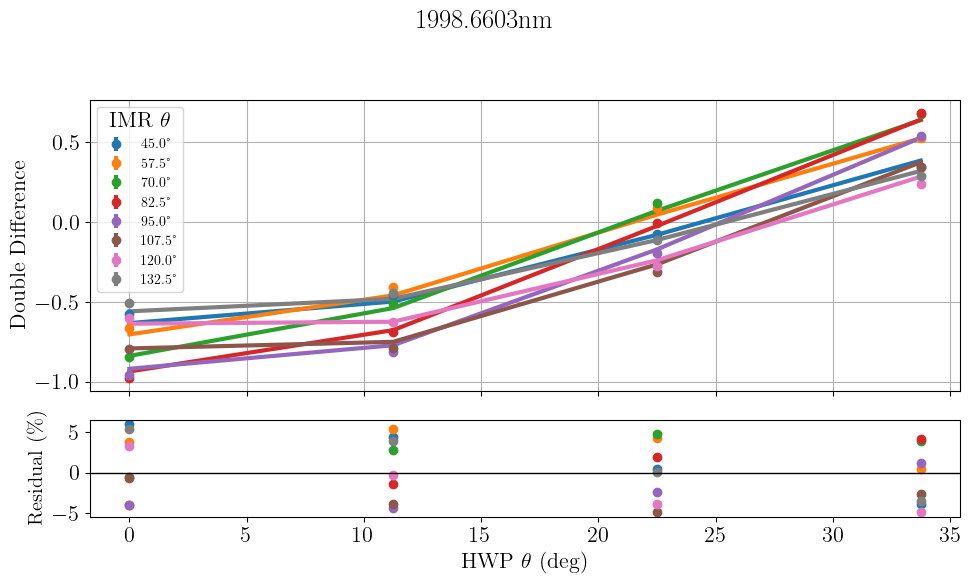

Updated Mueller Matrix:
[[ 0.3141168   0.27944713  0.0703625   0.12501113]
 [-0.3141168  -0.27944713 -0.0703625  -0.12501113]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.04888688535259361 0.05973073097893189
Error: [ 0.02537858  0.95078075  0.05111571  6.72316587 13.41038169  0.01566491]
dataset: [-0.57689318 -0.45879186 -0.07515969  0.35194424 -0.66645317 -0.41260969
  0.08013522  0.52602552 -0.84047808 -0.51612195  0.10781242  0.66894007
 -0.9715259  -0.69273743 -0.0120089   0.67644805 -0.95877446 -0.81400528
 -0.19326838  0.54060768 -0.80755973 -0.78997388 -0.30627804  0.35757614
 -0.62281744 -0.63408923 -0.27044309  0.25453472 -0.5306121  -0.45613126
 -0.10959002  0.30364582]
errors: [4.33849047e-05 4.33679810e-05 4.34293947e-05 4.33596820e-05
 4.33769971e-05 4.34362858e-05 4.35082884e-05 4.34240757e-05
 4.34351214e-05 4.34917578e-05 4.35730119e-05 4.35121864e-05
 4.34231459e-05 4.34784065e-05 4.35

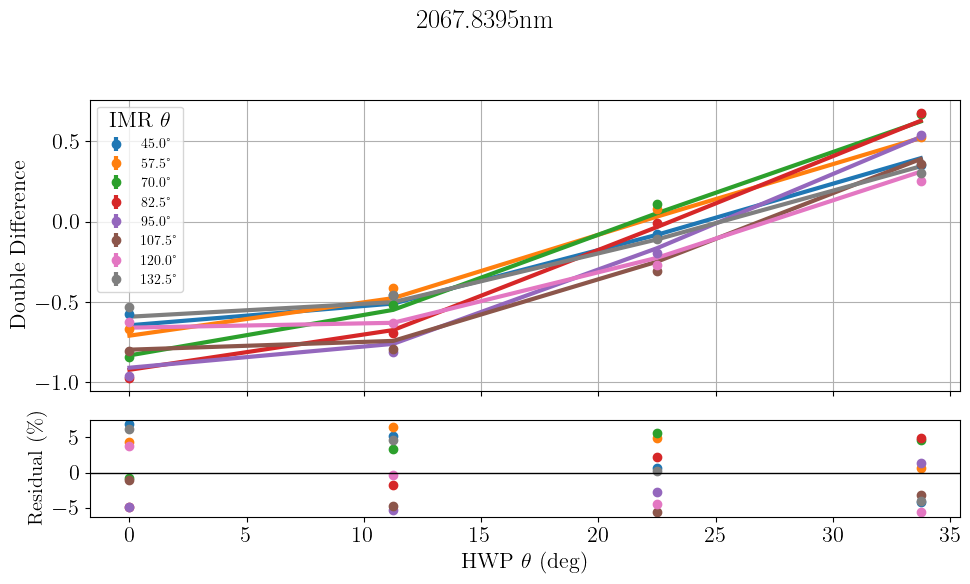

Updated Mueller Matrix:
[[ 0.31008015  0.26561195  0.08682161  0.13439494]
 [-0.31008015 -0.26561195 -0.08682161 -0.13439494]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.05669370215779679 0.06848321121983769
Error: [3.19150477e-02 1.24013129e+00 6.28457583e-02 1.09780425e+01
 2.19202822e+01 1.84822411e-02]
dataset: [-0.5685823  -0.45315901 -0.07212133  0.35033281 -0.6590194  -0.40901531
  0.07996102  0.52259185 -0.83463791 -0.51427068  0.10623652  0.66571786
 -0.96872285 -0.69273692 -0.0129606   0.67533384 -0.9619091  -0.81564099
 -0.1923721   0.54300465 -0.81750762 -0.79420995 -0.30382364  0.36352414
 -0.63819581 -0.64114202 -0.26723472  0.26368496 -0.54806077 -0.46391648
 -0.10661099  0.31440682]
errors: [4.88086749e-05 4.87958943e-05 4.88446432e-05 4.87751647e-05
 4.87927079e-05 4.88734346e-05 4.89325163e-05 4.88530760e-05
 4.88462720e-05 4.89377164e-05 4.90134875e-05 4.89186412e-05
 4.88269406e-05 

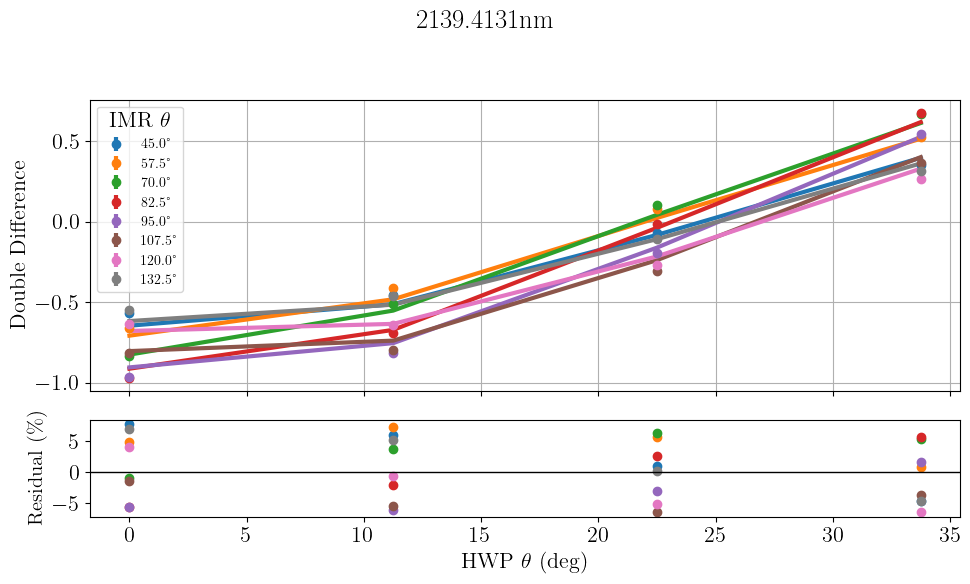

Updated Mueller Matrix:
[[ 0.30965854  0.2591056   0.09926325  0.13747548]
 [-0.30965854 -0.2591056  -0.09926325 -0.13747548]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.06535787101212759 0.0773596137538397
Error: [3.81261245e-02 1.51745789e+00 7.38290911e-02 2.33313438e+01
 4.66299597e+01 2.13193422e-02]
dataset: [-0.5462018  -0.43594145 -0.06674166  0.34156709 -0.638032   -0.39275358
  0.08545132  0.51481622 -0.81949848 -0.50129538  0.11095912  0.66008683
 -0.96183974 -0.68441502 -0.00970524  0.67131659 -0.96060493 -0.81169868
 -0.19078339  0.54030914 -0.81855946 -0.79211138 -0.30259079  0.36155919
 -0.64108685 -0.63932172 -0.2651135   0.26370479 -0.55302184 -0.46146052
 -0.10308626  0.31626133]
errors: [5.37389777e-05 5.36813813e-05 5.36830990e-05 5.36479302e-05
 5.37847804e-05 5.37582002e-05 5.37810179e-05 5.37819318e-05
 5.39242594e-05 5.38580612e-05 5.38695505e-05 5.39012775e-05
 5.40150905e-05 5

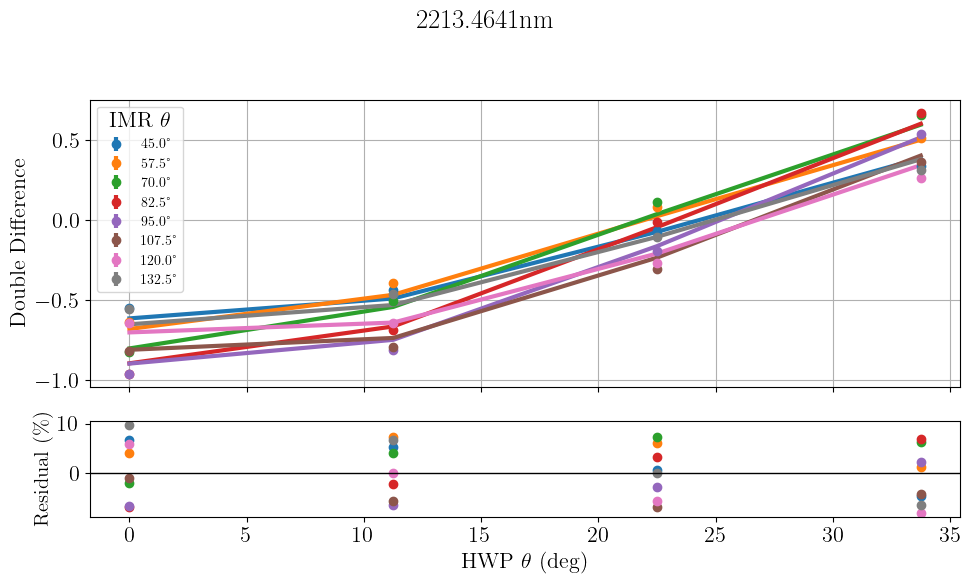

Updated Mueller Matrix:
[[ 0.3209233   0.26137488  0.12075046  0.14175425]
 [-0.3209233  -0.26137488 -0.12075046 -0.14175425]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.07983187181015866 0.09668916575849174
Error: [4.43568005e-02 1.78061225e+00 8.08703280e-02 2.58785540e+01
 5.17562215e+01 2.45443227e-02]
dataset: [-0.51536444 -0.41215409 -0.05832587  0.33031351 -0.61169679 -0.37177558
  0.09354766  0.50538427 -0.80067873 -0.48591564  0.11682174  0.65331149
 -0.94987055 -0.67588289 -0.00689619  0.66679638 -0.95727112 -0.80983261
 -0.19114147  0.53718037 -0.82323721 -0.79434012 -0.3042296   0.36071803
 -0.64999911 -0.64234758 -0.26598542  0.26472182 -0.56372062 -0.46420971
 -0.10151015  0.3196272 ]
errors: [6.26795010e-05 6.26052687e-05 6.25809314e-05 6.25494597e-05
 6.27044428e-05 6.26978335e-05 6.26985344e-05 6.27023241e-05
 6.28029707e-05 6.28119897e-05 6.28137833e-05 6.28143221e-05
 6.29235860e-05 

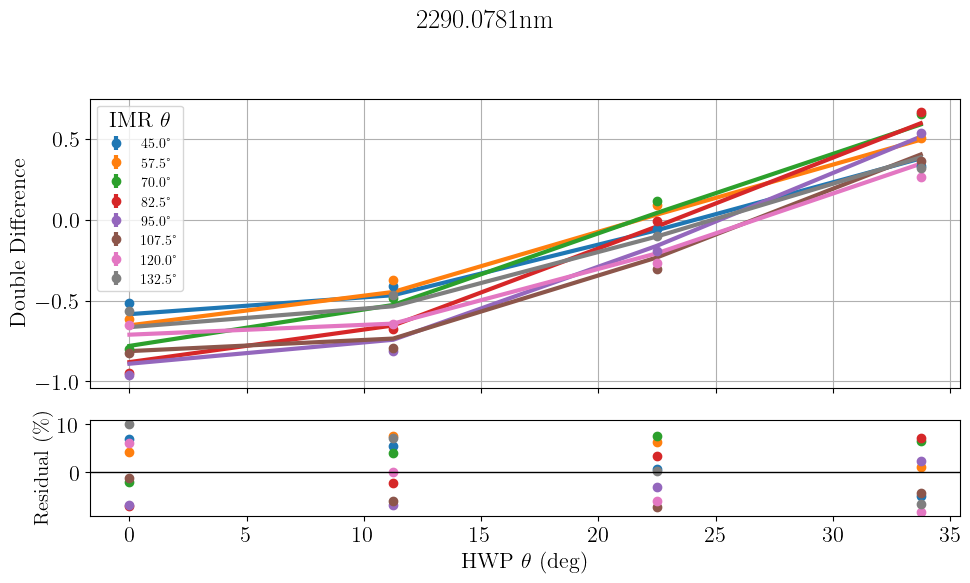

Updated Mueller Matrix:
[[ 0.3312528   0.26823872  0.1316156   0.14301656]
 [-0.3312528  -0.26823872 -0.1316156  -0.14301656]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.0810695379165205 0.10055434829304388
Error: [ 0.04592246  1.83220885  0.08307734 12.42413986 24.83282208  0.02555778]
dataset: [-4.71677503e-01 -3.82133811e-01 -5.48961766e-02  3.05889458e-01
 -5.71908291e-01 -3.38756102e-01  1.05155067e-01  4.90848069e-01
 -7.73652983e-01 -4.59363782e-01  1.30018619e-01  6.47436464e-01
 -9.37021753e-01 -6.60886588e-01  9.14275379e-05  6.62413448e-01
 -9.47942947e-01 -8.02541366e-01 -1.92127954e-01  5.26938394e-01
 -8.08272604e-01 -7.85411182e-01 -3.08772713e-01  3.43065750e-01
 -6.29164242e-01 -6.26013684e-01 -2.66741181e-01  2.46302440e-01
 -5.42738979e-01 -4.40308210e-01 -9.42459412e-02  3.06011247e-01]
errors: [7.38423625e-05 7.38183019e-05 7.38339310e-05 7.38219780e-05
 7.40045011e-05 7.38957829e-

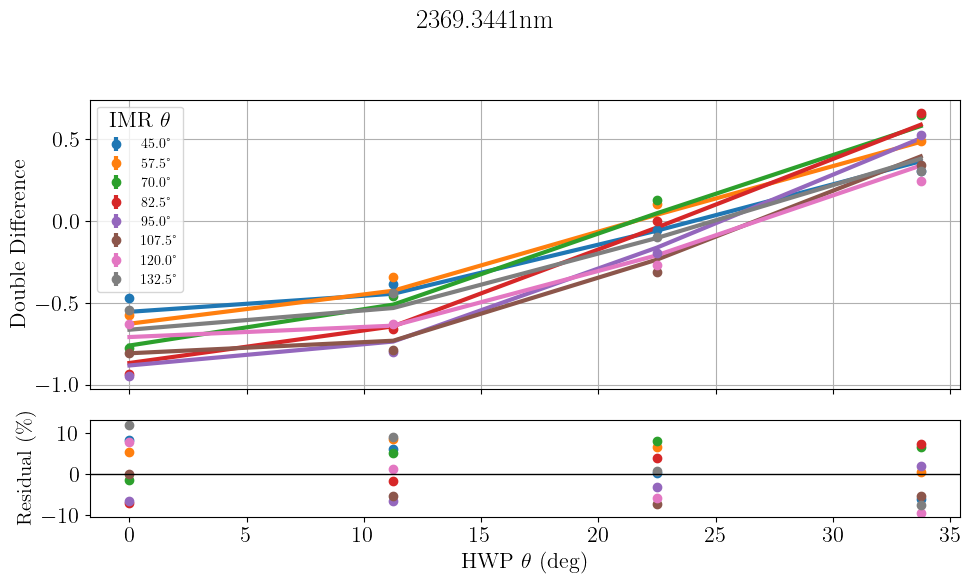

Updated Mueller Matrix:
[[ 0.34117218  0.27352465  0.14040935  0.14787813]
 [-0.34117218 -0.27352465 -0.14040935 -0.14787813]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
32 64
Residuals range: -0.09368169100712248 0.12091787712845736
Error: [ 0.05108761  2.00716557  0.09232221 10.21615757 20.40192748  0.02889712]


In [4]:
# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
    error = fit_CHARIS_Mueller_matrix_by_bin(
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff_dd.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/dd_fit_dicts/sysdictbin{bin}nopick.json'),
        plot_path=Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/dd_fit_plots/bin{bin}nopick.png')
    )[0]
    errors.append(error)


In [8]:
# find average error
errors = np.array(errors)
print('hwp_ret', np.mean(errors[:,0]))
print('hwp_offset', np.mean(errors[:,1]))
print('imr_ret',np.mean(errors[:,2]))
print('imr_offset', np.mean(errors[:,3]))
print('epsilon_cal', np.mean(errors[:,4]))
print('cal_offset', np.mean(errors[:,5]))



    

hwp_ret 0.01301062943478881
hwp_offset 0.5517815520231594
imr_ret 0.024895886354269123
imr_offset 4.782795468200765
epsilon_cal 9.49627909681065
cal_offset 0.0075299380883503


In [6]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/dd_fit_dicts'
df = model_data(json_dir)
df

wavelength_bin  hwp_retardance  imr_retardance  \
0        1159.5614        2.988628        4.311998   
1        1199.6971        2.989263        4.037161   
2        1241.2219        3.005751        3.808595   
3        1284.1840        3.017857        3.533371   
4        1328.6331        3.106059        3.302456   
5        1374.6208        3.018336        2.752056   
6        1422.2002        2.996001        2.474125   
7        1471.4264        2.990645        2.194127   
8        1522.3565        2.985402        1.943020   
9        1575.0495        2.983849        1.730250   
10       1629.5663        2.986147        1.529401   
11       1685.9701        2.990485        1.365877   
12       1744.3261        2.997502        1.248350   
13       1804.7021        3.008624        1.150466   
14       1867.1678        3.013064        1.035290   
15       1931.7956        3.024631        0.947384   
16       1998.6603        3.038155        0.883334   
17       2067.8395        3.063500        0.839936   
18       2139.4131        3.098229        0.814041   
19       2213.4641        3.192969        0.800300   
20       2290.0781        3.252264        0.802597   
21       2369.3441        3.291790        0.815376   

    calibration_polarizer_diattenuation  hwp_offset  hwp_offset_std  \
0                              1.000000   -1.276827        1.893359   
1                              0.988696   -1.276827        1.893359   
2                              0.992169   -1.276827        1.893359   
3                              0.985325   -1.276827        1.893359   
4                              0.982450   -1.276827        1.893359   
5                              0.986161   -1.276827        1.893359   
6                              0.985760   -1.276827        1.893359   
7                              0.987910   -1.276827        1.893359   
8                              0.986748   -1.276827        1.893359   
9                              0.988764   -1.276827        1.893359   
10                             0.988609   -1.276827        1.893359   
11                             0.989911   -1.276827        1.893359   
12                             0.991333   -1.276827        1.893359   
13                             0.991396   -1.276827        1.893359   
14                             0.978676   -1.276827        1.893359   
15                             0.963241   -1.276827        1.893359   
16                             0.950161   -1.276827        1.893359   
17                             0.936723   -1.276827        1.893359   
18                             0.928298   -1.276827        1.893359   
19                             0.914422   -1.276827        1.893359   
20                             0.908119   -1.276827        1.893359   
21                             0.900000   -1.276827        1.893359   

    imr_offset  imr_offset_std  cal_offset  cal_offset_std  
0     0.021368        0.506121   -0.373229        3.404573  
1     0.021368        0.506121   -0.373229        3.404573  
2     0.021368        0.506121   -0.373229        3.404573  
3     0.021368        0.506121   -0.373229        3.404573  
4     0.021368        0.506121   -0.373229        3.404573  
5     0.021368        0.506121   -0.373229        3.404573  
6     0.021368        0.506121   -0.373229        3.404573  
7     0.021368        0.506121   -0.373229        3.404573  
8     0.021368        0.506121   -0.373229        3.404573  
9     0.021368        0.506121   -0.373229        3.404573  
10    0.021368        0.506121   -0.373229        3.404573  
11    0.021368        0.506121   -0.373229        3.404573  
12    0.021368        0.506121   -0.373229        3.404573  
13    0.021368        0.506121   -0.373229        3.404573  
14    0.021368        0.506121   -0.373229        3.404573  
15    0.021368        0.506121   -0.373229        3.404573  
16    0.021368        0.506121   -0.373229        3.404573  
17    0.021368        0.50612

In [8]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [10]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,2]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 27975.50780684113
        x: [ 1.667e+00  1.301e+00  2.599e+02]
      nit: 9
      jac: [ 3.087e+03 -4.017e+03 -3.599e+00]
     nfev: 120
     njev: 30
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 27975.507604473434
        x: [ 1.667e+00  1.301e+00  2.599e+02]
      nit: 2
      jac: [ 1.423e+00  1.418e+02 -3.591e+00]
     nfev: 136
     njev: 34
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [9]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,2]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 27508.67642875656
        x: [ 1.668e+00  1.302e+00  2.599e+02]
      nit: 7
      jac: [-7.680e+02  1.066e+03 -5.657e-01]
     nfev: 88
     njev: 22
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 27508.676417596624
        x: [ 1.668e+00  1.302e+00  2.599e+02]
      nit: 1
      jac: [ 1.587e+01  9.510e+00 -6.035e-01]
     nfev: 16
     njev: 4
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
